## IMU logger and jump height estimation

### Imports

In [9]:
import serial 
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from collections import deque
import pandas as pd 

### IMU Logger

In [11]:

# Serial config
PORT = '/dev/cu.usbmodem1101'  
BAUD = 115200 # Baud rate for IMU data
ser = serial.Serial(PORT, BAUD, timeout=1)

# Output CSV file
filename = f"imu_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv" # Timestamped filename
fields = ['timestamp', 'temp_C', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
csv_file = open(filename, mode='w', newline='')
writer = csv.DictWriter(csv_file, fieldnames=fields)
writer.writeheader()

# Function to parse a line of IMU data
def parse_line(line):
    try:
        line = line.decode('utf-8').strip()

        if line.startswith("Degrees C1"):
            temp = float(line.split('=')[1])
            return {'temp_C': temp}

        elif line.startswith("X1 ="):
            # Accelerometer or Gyro block
            values = [float(x.split('=')[1]) for x in line.split()]
            return values

    except Exception as e:
        print("Parse error:", e)
        return None

# Buffers for sensor data 
temp = None
accel = [0, 0, 0]
gyro = [0, 0, 0]

print("Logging IMU data...")

try:
    while True:
        line = ser.readline()
        if not line:
            continue

        if b"Degrees C1" in line:
            temp = parse_line(line)['temp_C']

        elif b"Accelerometer" in line:
            accel = [float(ser.readline().decode().split('=')[1]) for _ in range(3)]

        elif b"Gyroscope" in line:
            gyro = [float(ser.readline().decode().split('=')[1]) for _ in range(3)]

            # Once all sensors are read, write row
            row = {
                'timestamp': time.time(),
                'temp_C': temp,
                'accel_x': accel[0],
                'accel_y': accel[1],
                'accel_z': accel[2],
                'gyro_x': gyro[0],
                'gyro_y': gyro[1],
                'gyro_z': gyro[2],
            }
            writer.writerow(row)
            print(row)

except KeyboardInterrupt:
    print("Logging stopped.")

finally:
    csv_file.close()
    ser.close()


Logging IMU data...
{'timestamp': 1757353433.3732638, 'temp_C': None, 'accel_x': -0.082, 'accel_y': -0.3709, 'accel_z': -0.9116, 'gyro_x': -0.56, 'gyro_y': -0.21, 'gyro_z': -0.63}
{'timestamp': 1757353433.373964, 'temp_C': 26.2305, 'accel_x': -0.0854, 'accel_y': -0.3728, 'accel_z': -0.916, 'gyro_x': -0.21, 'gyro_y': 0.07, 'gyro_z': -0.42}
{'timestamp': 1757353434.266293, 'temp_C': 26.2813, 'accel_x': -0.083, 'accel_y': -0.3684, 'accel_z': -0.916, 'gyro_x': -0.49, 'gyro_y': -0.07, 'gyro_z': -0.49}
{'timestamp': 1757353435.278357, 'temp_C': 26.2422, 'accel_x': -0.082, 'accel_y': -0.3714, 'accel_z': -0.915, 'gyro_x': 0.42, 'gyro_y': -0.07, 'gyro_z': -0.56}
{'timestamp': 1757353436.2902982, 'temp_C': 26.2539, 'accel_x': -0.9755, 'accel_y': -2.9617, 'accel_z': -1.1624, 'gyro_x': 1352.54, 'gyro_y': -149.94, 'gyro_z': 185.78}
{'timestamp': 1757353437.3010108, 'temp_C': 26.2188, 'accel_x': 0.468, 'accel_y': -0.8355, 'accel_z': 0.2113, 'gyro_x': -13.37, 'gyro_y': -7.77, 'gyro_z': 6.16}
{'timest

### Smoothing - EMA

In [30]:
data = pd.read_csv(filename)

# Simple exponential moving average (EMA) smoothing
alpha = 0.1  # Smoothing factor between 0 (heavy smoothing) and 1 (no smoothing)

for col in ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
    data[f'{col}_filt'] = data[col].ewm(alpha=alpha).mean()

### Smoothing - Kalman

In [31]:
# Kalman filter for smoothing
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        kalman_gain = priori_error_estimate / (priori_error_estimate + self.measurement_variance)
        self.posteri_estimate = priori_estimate + kalman_gain * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - kalman_gain) * priori_error_estimate

        return self.posteri_estimate
    
# Initialize Kalman filters for each axis
kf_accel_x = KalmanFilter(1e-5, 0.1)
kf_accel_y = KalmanFilter(1e-5, 0.1)
kf_accel_z = KalmanFilter(1e-5, 0.1)  
kf_gyro_x = KalmanFilter(1e-5, 0.1)
kf_gyro_y = KalmanFilter(1e-5, 0.1)
kf_gyro_z = KalmanFilter(1e-5, 0.1)  

# Read logged data and apply Kalman filter
data['accel_x_kfilt'] = data['accel_x'].apply(kf_accel_x.update)
data['accel_y_kfilt'] = data['accel_y'].apply(kf_accel_y.update)
data['accel_z_kfilt'] = data['accel_z'].apply(kf_accel_z.update) 
data['gyro_x_kfilt'] = data['gyro_x'].apply(kf_gyro_x.update)
data['gyro_y_kfilt'] = data['gyro_y'].apply(kf_gyro_y.update)
data['gyro_z_kfilt'] = data['gyro_z'].apply(kf_gyro_z.update)


In [32]:
# Snapshot of filtered data
print(data.head())

      timestamp   temp_C  accel_x  accel_y  accel_z   gyro_x  gyro_y  gyro_z  \
0  1.757353e+09      NaN  -0.0820  -0.3709  -0.9116    -0.56   -0.21   -0.63   
1  1.757353e+09  26.2305  -0.0854  -0.3728  -0.9160    -0.21    0.07   -0.42   
2  1.757353e+09  26.2813  -0.0830  -0.3684  -0.9160    -0.49   -0.07   -0.49   
3  1.757353e+09  26.2422  -0.0820  -0.3714  -0.9150     0.42   -0.07   -0.56   
4  1.757353e+09  26.2539  -0.9755  -2.9617  -1.1624  1352.54 -149.94  185.78   

   accel_x_filt  accel_y_filt  accel_z_filt  gyro_x_filt  gyro_y_filt  \
0     -0.082000     -0.370900     -0.911600    -0.560000    -0.210000   
1     -0.083789     -0.371900     -0.913916    -0.375789    -0.062632   
2     -0.083498     -0.370608     -0.914685    -0.417934    -0.065351   
3     -0.083063     -0.370839     -0.914777    -0.174277    -0.066703   
4     -0.300991     -1.003512     -0.975245   330.150813   -36.664905   

   gyro_z_filt  accel_x_kfilt  accel_y_kfilt  accel_z_kfilt  gyro_x_kfilt  \
0  

### Plots - simple

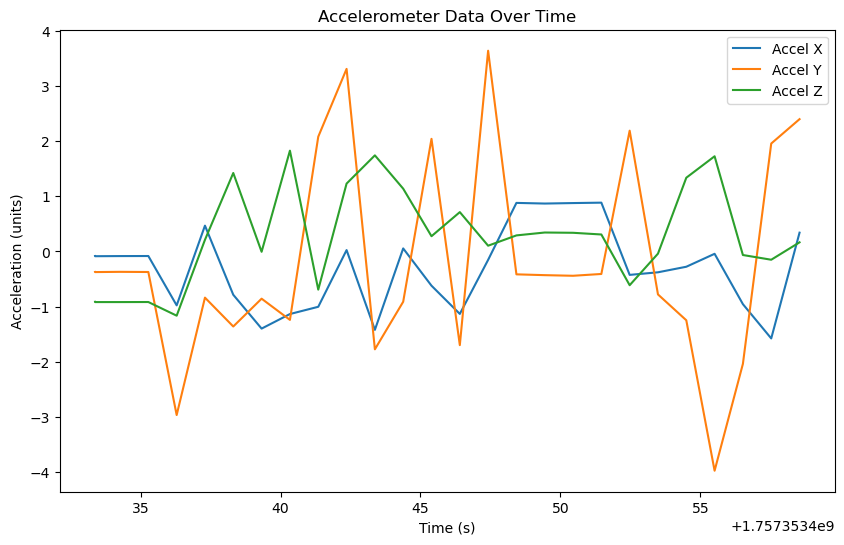

In [14]:
# plot accel data
plt.figure(figsize=(10,6))
plt.plot(data['timestamp'], data['accel_x'], label='Accel X')
plt.plot(data['timestamp'], data['accel_y'], label='Accel Y')
plt.plot(data['timestamp'], data['accel_z'], label='Accel Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (units)')
plt.title('Accelerometer Data Over Time')
plt.legend()
plt.show()  

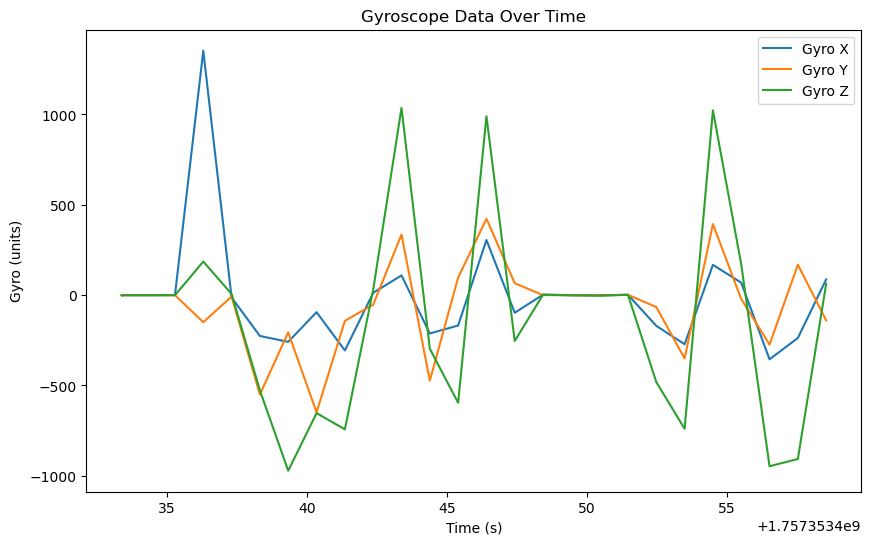

In [13]:
# Plot gyro data
data = pd.read_csv(filename)
plt.figure(figsize=(10,6))
plt.plot(data['timestamp'], data['gyro_x'], label='Gyro X')
plt.plot(data['timestamp'], data['gyro_y'], label='Gyro Y')
plt.plot(data['timestamp'], data['gyro_z'], label='Gyro Z')
plt.xlabel('Time (s)')
plt.ylabel('Gyro (units)')
plt.title('Gyroscope Data Over Time')
plt.legend()
plt.show()



### Plots - filtered

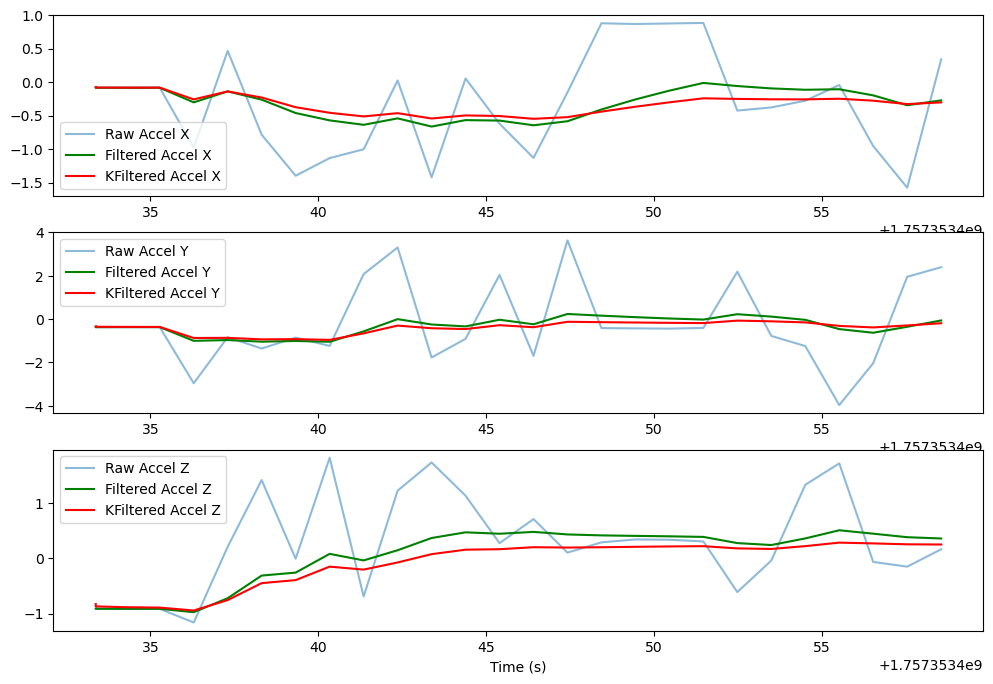

In [33]:
# Plot raw vs filtered data for accelerometer
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data['timestamp'], data['accel_x'], label='Raw Accel X', alpha=0.5)
plt.plot(data['timestamp'], data['accel_x_filt'], label='Filtered Accel X', color='green')
plt.plot(data['timestamp'], data['accel_x_kfilt'], label='KFiltered Accel X', color='red')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data['timestamp'], data['accel_y'], label='Raw Accel Y', alpha=0.5)
plt.plot(data['timestamp'], data['accel_y_filt'], label='Filtered Accel Y', color='green')
plt.plot(data['timestamp'], data['accel_y_kfilt'], label='KFiltered Accel Y', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(data['timestamp'], data['accel_z'], label='Raw Accel Z', alpha=0.5)
plt.plot(data['timestamp'], data['accel_z_filt'], label='Filtered Accel Z', color='green')
plt.plot(data['timestamp'], data['accel_z_kfilt'], label='KFiltered Accel Z', color='red')
plt.legend()
plt.xlabel('Time (s)')
plt.show()

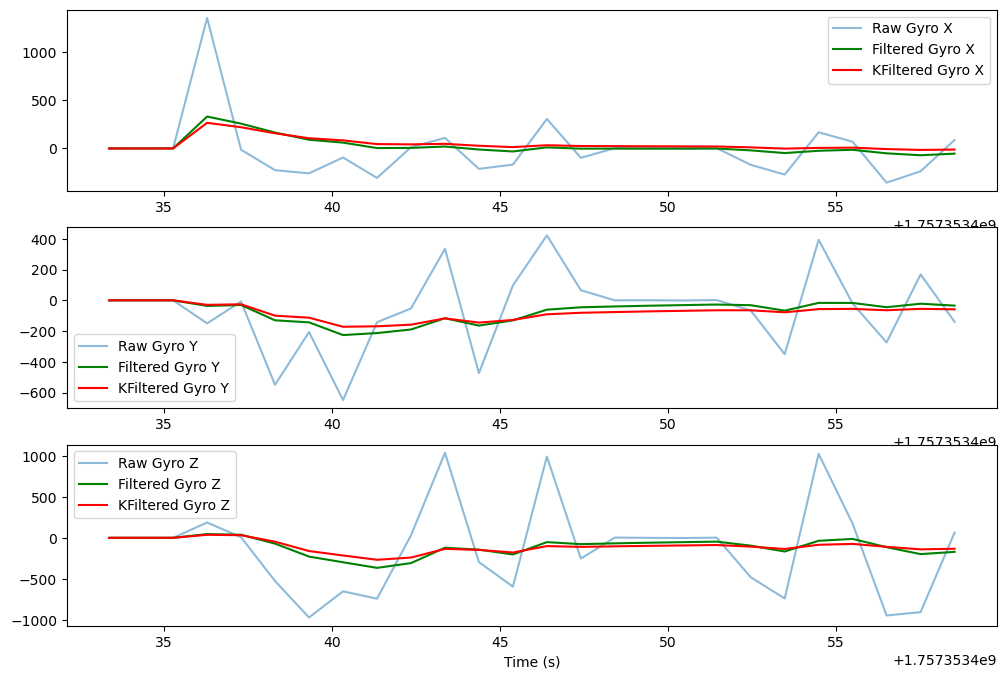

In [34]:
# Plot raw vs filtered data for gyroscope
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data['timestamp'], data['gyro_x'], label='Raw Gyro X', alpha=0.5)
plt.plot(data['timestamp'], data['gyro_x_filt'], label='Filtered Gyro X', color='green')
plt.plot(data['timestamp'], data['gyro_x_kfilt'], label='KFiltered Gyro X', color='red')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data['timestamp'], data['gyro_y'], label='Raw Gyro Y', alpha=0.5)
plt.plot(data['timestamp'], data['gyro_y_filt'], label='Filtered Gyro Y', color='green')
plt.plot(data['timestamp'], data['gyro_y_kfilt'], label='KFiltered Gyro Y', color='red')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(data['timestamp'], data['gyro_z'], label='Raw Gyro Z', alpha=0.5)
plt.plot(data['timestamp'], data['gyro_z_filt'], label='Filtered Gyro Z', color='green')
plt.plot(data['timestamp'], data['gyro_z_kfilt'], label='KFiltered Gyro Z', color='red')
plt.legend()
plt.xlabel('Time (s)')
plt.show()
